# Anomaly Detection (Binary 3D)


**Inputs**  


The 14 waveforms (features) reported in the dataset in order are:

- `A+IGBT-I`: Current passing through the IGBT switch of phase A+ in Qa1 ($A$).  
- `A+*IGBT-I`: Current passing through the IGBT switch of phase A+\* in Qa3 ($A$).  
- `B+IGBT-I`: Current passing through the IGBT switch of phase B+ in Qb1 ($A$).  
- `B+*IGBT-I`: Current passing through the IGBT switch of phase B+\* in Qb3 ($A$).  
- `C+IGBT-I`: Current passing through the IGBT switch of phase C+ in Qc1 ($A$).  
- `C+*IGBT-I`: Current passing through the IGBT switch of phase C+\* in Qc3 ($A$).  
- `A-Flux`: Magnetic flux density for phase A in transformer XA ($-$).  
- `B-Flux`: Magnetic flux density for phase B in transformer XB ($-$).  
- `C-Flux`: Magnetic flux density for phase C in transformer XC ($-$).  
- `Mod-V`: Modulator voltage ($V$).  
- `Mod-I`: Modulator current ($A$).  
- `CB-I`: Cap bank current ($-$).  
- `CB-V`: Cap bank voltage ($V$).  
- `DV/DT`: Time derivative change of the Mod\-V voltage ($-$).

**Outputs**
- `Fault`: Faulty wave pulse
- `Normal` Normal wave pulse

![Image](supporting/anomaly/figs/display.jpg)





The files provided in the dataset are:

- `RFQ.npy`: 3D numpy array of the normal and faulty pulses for the RFQ system (shape: (872, 4500, 14)).
- `RFQ_labels.npy`: 2D numpy array of the labels for the RFQ system (shape: (872, 3)).
- `DTL.npy`: 3D numpy array of the normal and faulty pulses for the DTL system (shape: (1077, 4500, 14)).
- `DTL_labels.npy`: 2D numpy array of the labels for the DTL system (shape: (1077, 3)).
- `CCL.npy`: 3D numpy array of the normal and faulty pulses for the CCL system (shape: (2057, 4500, 14)).
- `CCL_labels.npy`: 2D numpy array of the labels for the CCL system (shape: (2057, 3)).
- `SCL.npy`: 3D numpy array of the normal and faulty pulses for the SCL system (shape: (4598, 4500, 14)).
- `SCL_labels.npy`: 2D numpy array of the labels for the SCL system (shape: (4598, 3)).



High Voltage Converter Modulators (HVCM) have frequent failures, making them a major source of down time for the Spallation neutron source. HVCMs are well instrumented to collect large amounts of waveform data including but not limited to modulator current, modulator voltage, magnetic flux, cap bank voltage, cap bank current, and others. These waveform data are collected from all 15 HVCM systems for the application of anomaly detection and failure prediction.

All 15 modulators are grouped into four major subsystems based on their type as follows: 1 modulator as radio-frequency quadrupole (RFQ), 2 modulators as drift-tube linac (DTL), 4 modulators as coupled-cavity linac (CCL), and 8 modulators as super-conducting linac (SCL). A waveform is featured by consecutive pulses, which could be either a normal pulse if the system is healthy, or anomaly pulse if the system is close to failing. These pulses are collected and reported in the dataset of this paper, where the details of the data collection and processing are described in the example.


![Image](supporting/anomaly/figs/data.jpg)

In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
sys.path.insert(0, "supporting/anomaly")

from supporting.anomaly.preprocessing import load_anomaly_data
import supporting.anomaly.settings as anomaly_settings
import pyMAISE as mai

2024-06-15 18:09:35.313594: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-15 18:09:35.313621: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-15 18:09:35.314690: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-15 18:09:35.319758: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-15 18:09:35.952937: W tensorflow/compiler/tf2

## pyMAISE Initialization
In the settings file, the researchers initialize pyMAISE as a classification problem and load the DTL data set. GPU is defined and utilized for LSTM and GRU models.

In [2]:
global_settings = mai.init(
    problem_type=anomaly_settings.problem_type,
    random_state=anomaly_settings.random_state,
    cuda_visible_devices="1",  # Use GPU 1
)

The settings file defines a 70/30 training and testing split. To train the machine learning models the researchers desire roughly a 50/50 split between `Fault` and `Normal`. There were significantly more `Normal` cases, so these `Normal` datapoints were removed at random points to preserve the sequential pattern of the time dataset.

![Frequency of positive/negative values in anomaly detection data.](supporting/anomaly/figs/bc1_frequency.png)

This plot shows the frequency of `Normal` and `Fault` cases with the trimmed positive data.


In [3]:
xtrain, xtest, ytrain, ytest, xscaler = load_anomaly_data(
    global_settings=global_settings,
    stack_series=False,
    multiclass=False,
    test_size=anomaly_settings.test_size,
    non_faulty_frac=anomaly_settings.non_faulty_frac,
    timestep_step=1,
)

xtrain shape: (303, 4500, 14)
xtest shape: (131, 4500, 14)
ytrain shape: (303, 2)
ytest shape: (131, 2)


In [4]:
xtrain

<xarray.DataArray (samples: 303, time steps: 4500, features: 14)>
array([[[0.60082346, 0.61243737, 0.8039878 , ..., 0.50022596,
         0.9679824 , 0.48880938],
        [0.60112906, 0.61243737, 0.80275345, ..., 0.50068575,
         0.9676206 , 0.49002638],
        [0.60082346, 0.61243737, 0.80357635, ..., 0.49930644,
         0.9677563 , 0.48637483],
        ...,
        [0.60265714, 0.6121174 , 0.80275345, ..., 0.49838698,
         0.9323018 , 0.4948948 ],
        [0.6017403 , 0.61147743, 0.80357635, ..., 0.4974674 ,
         0.93194   , 0.49489477],
        [0.6017403 , 0.6111575 , 0.80275345, ..., 0.49838698,
         0.9321661 , 0.49489462]],

       [[0.60112906, 0.49980605, 0.80275345, ..., 0.50022596,
         0.9535112 , 0.49489477],
        [0.6017403 , 0.49980605, 0.80275345, ..., 0.50068575,
         0.9545513 , 0.49611187],
        [0.6017403 , 0.49980605, 0.80357635, ..., 0.50022596,
         0.9551392 , 0.49367765],
...
        [0.60846364, 0.61467725, 0.80645657, ..., 0.49838698,
         0.8540802 , 0.5168022 ],
        [0.609075  , 0.61499727, 0.80645657, ..., 0.49930644,
         0.85442394, 0.5119318 ],
        [0.60846364, 0.6156371 , 0.80522215, ..., 0.4974674 ,
         0.85442394, 0.51801854]],

       [[0.60112906, 0.61243737, 0.802342  , ..., 0.49930644,
         0.95337546, 0.48880938],
        [0.6005178 , 0.6127573 , 0.80275345, ..., 0.49930644,
         0.95305896, 0.49246046],
        [0.60112906, 0.61243737, 0.802342  , ..., 0.49838698,
         0.95328504, 0.49611172],
        ...,
        [0.60082346, 0.6111575 , 0.80069613, ..., 0.50068575,
         0.91760445, 0.51558584],
        [0.6023515 , 0.6117974 , 0.8011076 , ..., 0.50022596,
         0.9181471 , 0.51315314],
        [0.6017403 , 0.61147743, 0.8019305 , ..., 0.49930644,
         0.9178306 , 0.5168022 ]]], dtype=float32)
Coordinates:
  * samples     (samples) int64 118 114 140 137 322 332 ... 71 106 270 348 102
  * time steps  (time steps) int64 0 1 2 3 4 5 ... 4494 4495 4496 4497 4498 4499
  * features    (features) <U18 'A+IGBT-I: current' ... 'DV/DT'

In [5]:
ytrain

<xarray.DataArray (samples: 303, features: 2)>
array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
...
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.]])
Coordinates:
  * samples   (samples) int64 118 114 140 137 322 332 ... 188 71 106 270 348 102
  * features  (features) object 'Class_Fault' 'Class_Run'

## Model Initialization and Hyperparameter Tuning

The researchers will compare the performance of 2 machine learning (ML) models:

- Long short-term memory: `LSTM`,
- Gated recurrent unit: `GRU`,

Both `LSTM` and `GRU` utilize input, output, and dense input/output layers, in order. The researchers define the hyperparameter search objective as accuracy, utilizing Bayesian optimization and 50 trials. This is used to find the best hyperparameters that maximize accuracy. The results are saved using `pickle` and imported to Jupyter.

![Convergence of Bayesian optimizer to best hyperparameter configuration.](supporting/anomaly/figs/bc1_convergence.png)

The search could not produce an LSTM/GRU configuration with performance better than ~0.65.

In [6]:
with open("supporting/anomaly/configs/binary_case_1.pkl", "rb") as f:
    configs = pickle.load(f)

2024-06-14 23:59:39.458062: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-14 23:59:39.487567: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-14 23:59:39.487792: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Model Postprocessing

With the models tuned and the top hyperparameters saved, we can now pass these models to the `pyMAISE.PostProcessor` for model comparison and analysis. We will increase the `LSTM` and `GRU` models epochs for better performance.

In [7]:
postprocessor = mai.PostProcessor(
    data=(xtrain, xtest, ytrain, ytest),
    model_configs=[configs],
    new_model_settings={
        "LSTM": {"fitting_params": {"epochs": 100}},
        "GRU": {"fitting_params": {"epochs": 100}},
    },
)

2024-06-14 23:59:42.154838: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2024-06-14 23:59:42.617634: I external/local_xla/xla/service/service.cc:168] XLA service 0x7b56df058ee0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-14 23:59:42.617656: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-06-14 23:59:42.620995: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1718423982.689268  828138 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


To compare the performance of these models, we will compute four metrics for both the training and testing data: 
- `Accuracy` = $\frac{\text{Number of Correct Predictions}}{\text{Number of Instances}}$
- `Recall`= $\frac{\text{True Positives}}{\text{True Positives}+\text{False Negatives}}$
- `Precision` = $\frac{\text{True Positives}}{\text{True Positives}+\text{False Positives}}$
- `F1`= $\frac{2*\text{Precision}*\text{Recall}}{\text{Precision}+\text{Recall}}$

In [8]:
postprocessor.metrics()

/home/jacc/anaconda3/envs/tf2.15/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/jacc/anaconda3/envs/tf2.15/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Model Types,Parameter Configurations,Train Accuracy,Train Recall,Train Precision,Train F1,Test Accuracy,Test Recall,Test Precision,Test F1
6,GRU,"{'GRU_input_0_units': 83, 'GRU_num_layers': 0,...",0.772277,0.672859,0.847465,0.684227,0.770992,0.729785,0.842058,0.733740
8,GRU,"{'GRU_input_0_units': 64, 'GRU_num_layers': 0,...",0.801980,0.711538,0.884170,0.731795,0.740458,0.690909,0.845455,0.684918
9,GRU,"{'GRU_input_0_units': 49, 'GRU_num_layers': 0,...",0.696370,0.617366,0.658800,0.621168,0.725191,0.692823,0.739881,0.695349
0,LSTM,"{'LSTM_input_0_units': 83, 'LSTM_num_layers': ...",0.742574,0.627295,0.842143,0.622267,0.687023,0.627273,0.824786,0.596681
2,LSTM,"{'LSTM_input_0_units': 58, 'LSTM_num_layers': ...",0.745875,0.629808,0.860507,0.625054,0.679389,0.618182,0.822034,0.582929
5,GRU,"{'GRU_input_0_units': 82, 'GRU_num_layers': 2,...",0.739274,0.620192,0.857914,0.610989,0.671756,0.609091,0.819328,0.568848
1,LSTM,"{'LSTM_input_0_units': 53, 'LSTM_num_layers': ...",0.732673,0.610577,0.855357,0.596551,0.656489,0.590909,0.814050,0.539633
4,LSTM,"{'LSTM_input_0_units': 133, 'LSTM_num_layers':...",0.749175,0.634615,0.861818,0.631952,0.648855,0.581818,0.811475,0.524463
3,LSTM,"{'LSTM_input_0_units': 82, 'LSTM_num_layers': ...",0.656766,0.500000,0.328383,0.396414,0.580153,0.500000,0.290076,0.367150
7,GRU,"{'GRU_input_0_units': 120, 'GRU_num_layers': 1...",0.600660,0.594994,0.586448,0.583209,0.572519,0.578828,0.577022,0.571295


Based on the performance above, the LSTM model is the top performing model. The top 3 models are GRU, and their corresponding accuracy scores are in the high and mid 70%'s.

Next, the best-performing model hyperparameters are shown.

In [9]:
for model in ["LSTM", "GRU"]:
    for key, value in postprocessor.get_params(model_type=model).to_dict().items():
        print(f"{key}: {value[0]}")
    print()

Model Types: LSTM
LSTM_input_0_units: 83
LSTM_num_layers: 0
LSTM_output_0_units: 48
LSTM_output_0_activation: tanh
Dense_num_layers: 4
Adam_learning_rate: 0.0006246069474994221
Adam_clipnorm: 1.1993848052367777
Adam_clipvalue: 0.31339591884338236
LSTM_0_units: 74
LSTM_0_activation: sigmoid
batch_size: 8
LSTM_1_units: 27
LSTM_1_activation: tanh
LSTM_2_units: 196
LSTM_2_activation: tanh
LSTM_3_units: 55
LSTM_3_activation: tanh
Dense_0_units: 159
Dense_1_units: 149
Dense_2_units: 88
Dense_3_units: 36

Model Types: GRU
GRU_input_0_units: 83
GRU_num_layers: 0
GRU_output_0_units: 48
GRU_output_0_activation: tanh
Dense_num_layers: 4
Adam_learning_rate: 0.0006246069474994221
Adam_clipnorm: 1.1993848052367777
Adam_clipvalue: 0.31339591884338236
GRU_0_units: 74
GRU_0_activation: sigmoid
batch_size: 8
GRU_1_units: 27
GRU_1_activation: tanh
GRU_2_units: 196
GRU_2_activation: tanh
GRU_3_units: 55
GRU_3_activation: tanh
Dense_0_units: 159
Dense_1_units: 149
Dense_2_units: 88
Dense_3_units: 36



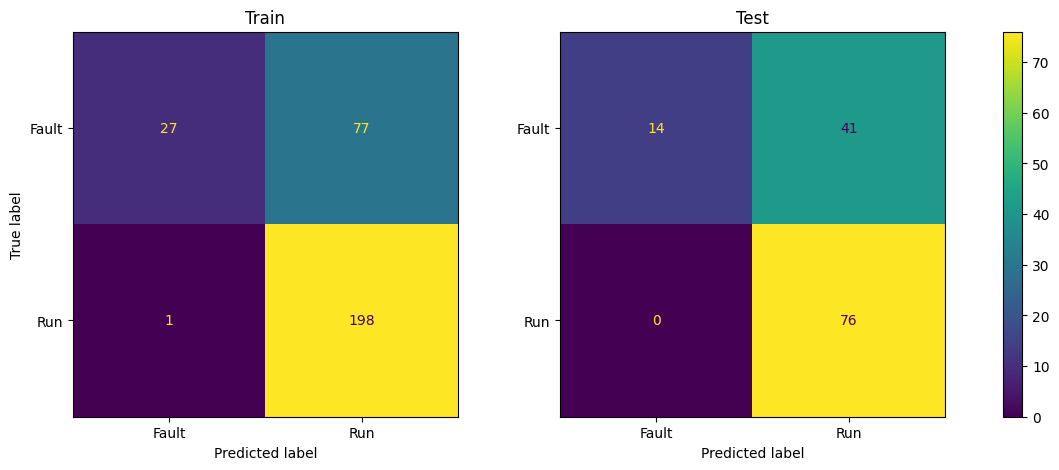

In [10]:
postprocessor.confusion_matrix(model_type="LSTM", figsize=(15, 5))
plt.show()

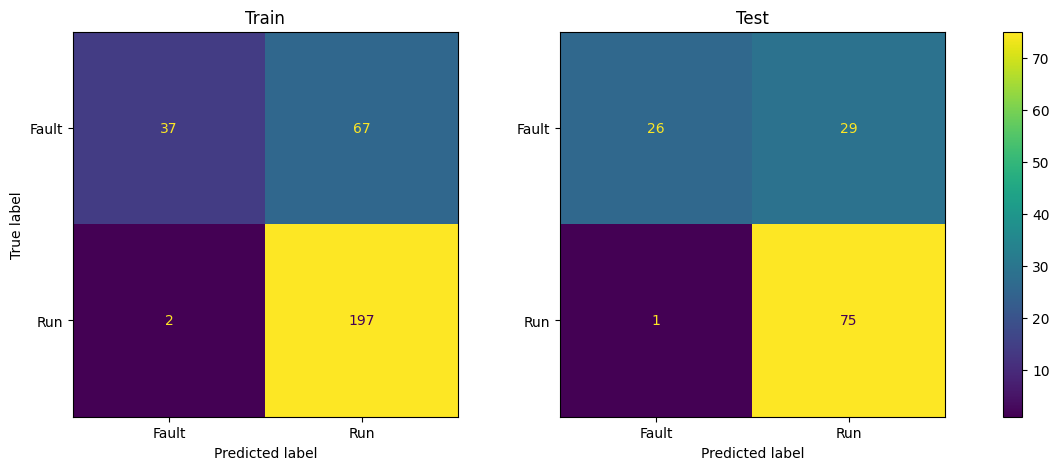

In [11]:
postprocessor.confusion_matrix(model_type="GRU", figsize=(15, 5))
plt.show()

The confusion matrix provides a visual of the predicted versus actual label values for the train and test sets, for LSTM and GRU respectively. Dispite having a relatively high accuracy, the models for both train and testing are heavily predicting `Run` labels. Accuracy for these models were between high 60%'s to high 70%'s.

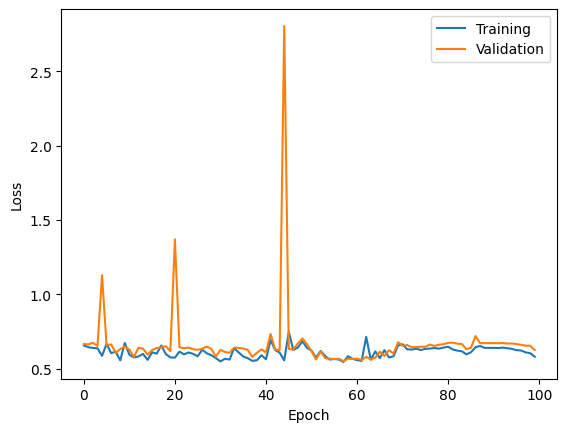

In [12]:
postprocessor.nn_learning_plot(model_type="LSTM")
plt.show()

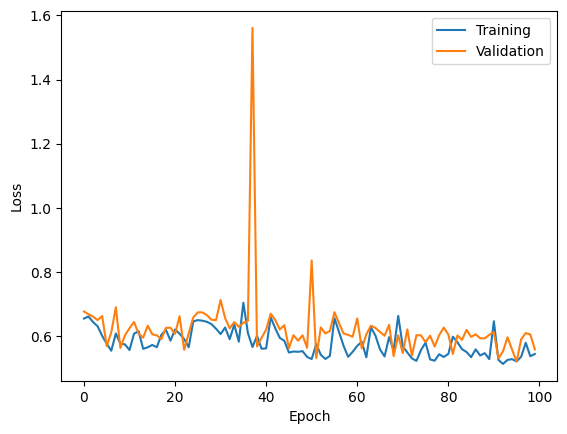

In [13]:
postprocessor.nn_learning_plot(model_type="GRU")
plt.show()

The model above shows slight overfitting, with the validation curve greater than the training curve.


![Image](supporting/anomaly/figs/pyMAISElogo.png)
